# **Deformable Convolution for Lung Cancer Prediction Based on Transcriptomic Data : ML Algorithms**
> Author : **Aymen MERROUCHE**. <br>
> In this notebook, we test Machien Learning Algorithms for our binary classification task. We use PCA for dimensionality reductionon :

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import datetime

from utils import *
from train import *
from data_utils import *
from modules.MLP import *
from modules.focal_loss import *
%load_ext autoreload
%autoreload 2

In [3]:
# device to use, if cuda available then use cuda else use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working on : ", device)

Working on :  cuda


In [4]:
# load hyperparametrs
# data paths args
with open('./configs/data_paths.yaml', 'r') as stream:
    data_paths_args  = yaml.load(stream,Loader=yaml.Loader)
    
    
# basic cnn args
with open('./configs/mlp.yaml', 'r') as stream:
    basic_cnn_args  = yaml.load(stream,Loader=yaml.Loader)

## **1 - Get the Data, Test Train Split, Random Over Sampling and Standard Scaling :**

In [5]:
%%time
# Getting the data
# dataset
lung_dataset = TranscriptomicVectorsDatasetLung(data_paths_args["path_to_pan_cancer_hdf5_files"])

CPU times: user 11.1 s, sys: 222 ms, total: 11.4 s
Wall time: 11.4 s


In [6]:
from sklearn.model_selection import train_test_split
X, y = lung_dataset.vectors.numpy(), lung_dataset.labels.numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print("len f train :",len(X_train))
print("len of test :",len(X_test))

len f train : 572
len of test : 283


In [8]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler 
# Random Over Sampling
print('Original dataset shape %s' % Counter(y_train))
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_ros))

Original dataset shape Counter({0: 519, 1: 53})
Resampled dataset shape Counter({0: 519, 1: 519})


In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_ros)
X_train_ros_sc = scaler.transform(X_train_ros)
X_test_sc = scaler.transform(X_test)

## **2 - PCA :**
> We want to get a minimum of variance accounted for of $0.95$.

Text(0, 0.5, 'cumulative explained variance')

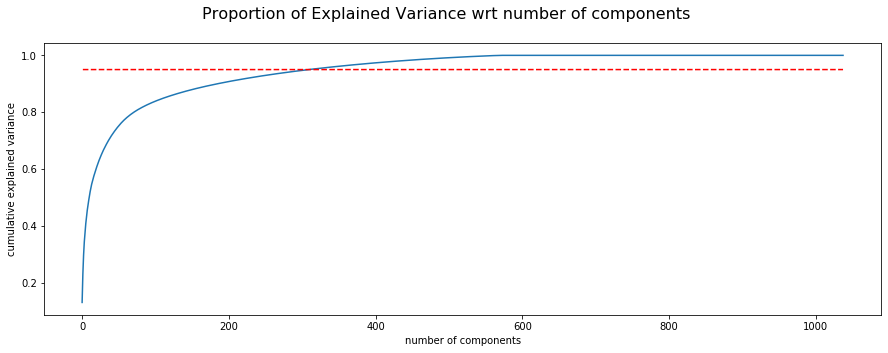

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

plt.figure(figsize=(15, 5))
plt.suptitle("Proportion of Explained Variance wrt number of components ", fontsize=16)
# get the data
pca = PCA().fit(X_train_ros_sc)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
xs = np.arange(1, len(pca.explained_variance_ratio_))
threshold = np.array([0.95 for i in range(len(pca.explained_variance_ratio_)-1)])
plt.plot(xs, threshold, 'r--') 
plt.plot()
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

> So to get a minimum of variance accounted for of $0.95$, we would take $\approx 300$ components.

In [11]:
# perform the PCA
# use sklearn's pca
n_components = 300
pca = PCA(n_components=n_components)
pca.fit(X_train_ros_sc)
X_train_ros_sc_pca = pca.transform(X_train_ros_sc)
X_test_sc_pca = pca.transform(X_test_sc)

In [12]:
X_train_ros_sc_pca.shape

(1038, 300)

In [13]:
X_test_sc_pca.shape

(283, 300)

In [14]:
import joblib

In [15]:
# save train data
joblib.dump(X_train_ros_sc_pca, './data_for_ml/X_train_ros_sc_pca.pkl')
joblib.dump(y_train_ros, './data_for_ml/y_train_ros.pkl')
# save test data
joblib.dump(X_test_sc_pca, './data_for_ml/X_test_sc_pca.pkl')
joblib.dump(y_test, './data_for_ml/y_test.pkl')

['./data_for_ml/y_test.pkl']

In [17]:
X_train_ros_sc_pca = joblib.load('./data_for_ml/X_train_ros_sc_pca.pkl')
y_train_ros = joblib.load('./data_for_ml/y_train_ros.pkl')
X_test_sc_pca = joblib.load('./data_for_ml/X_test_sc_pca.pkl')
y_test = joblib.load('./data_for_ml/y_test.pkl')

## **3 - Grid Search on ML Algorithms :**


In [59]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [45]:
# SVM
svm_clf = SVC()
parameter_space_svm = {
    "C" : [0.1, 0.5, 1],
    "kernel" : ["linear", "poly", "rbf", "sigmoid"],
    "gamma" : ["scale", "auto"]
}
# Random forests
rf_clf = RandomForestClassifier(random_state=0)
parameter_space_rf = {
    "criterion" : ["gini", "entropy"],
    "max_depth" : [2, 5, 10, None],
    "max_features" : ["auto", "sqrt", "log2", None],
    "n_estimators" : [50, 100, 200, 300],
    "n_jobs" : [-1]
}
# Gradient Boosting
gb_clf = GradientBoostingClassifier(random_state = 0)
parameter_space_gb = {
    "learning_rate" : [0.1, 0.5, 1],
    "n_estimators" : [50, 100, 200, 300],
    "criterion" : ["friedman_mse", "mse", "mae"],
    "max_depth" : [2, 5, 10, 15]
}
classifiers_ml = {"svm" : svm_clf, "random forests" : rf_clf, "gradient boosting" : gb_clf}
param_grids_ml = {"svm" : parameter_space_svm, "random forests" : parameter_space_rf, "gradient boosting" : parameter_space_gb}
# create keys for results
results = {clf : {"best cross val AUC" :0, "best cross val std":0, "AUC on test":0} for clf in classifiers_ml}
print(results)

{'svm': {'best cross val AUC': 0, 'best cross val std': 0, 'AUC on test': 0}, 'random forests': {'best cross val AUC': 0, 'best cross val std': 0, 'AUC on test': 0}, 'gradient boosting': {'best cross val AUC': 0, 'best cross val std': 0, 'AUC on test': 0}}


In [70]:
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc

# define scoring function 
def auc_score(target, preds):
    fpr, tpr, _ = roc_curve(target, preds[:, 1], pos_label=1)    
    return auc(fpr, tpr)

# to be standart sklearn's scorer        
auc_grid_search = make_scorer(auc_score, greater_is_better=True, needs_proba=True)

In [60]:
%%time
for clf in classifiers_ml:
    print("-"+clf+" : ")
    gs_clf = GridSearchCV(classifiers_ml[clf], param_grids_ml[clf], n_jobs=-1, cv=2, verbose=1)
    gs_clf.fit(X, y)
    test_preds = gs_clf.best_estimator_.predict(X_test_sc_pca)
    results[clf]["AUC on test"] = auc_score(y_test, test_preds)
    results[clf]["best cross val AUC"] = gs_clf.best_score_
    results[clf]["best cross val std"] = gs_clf.cv_results_['std_test_score'][gs_clf.best_index_]
    print("\t best params for "+clf+" : "+str(gs_clf.best_params_))
    print("\t Cross Val score of best "+clf+" : "+str(results[clf]["best cross val acc"]))
    print("\t AUC on test set of best "+clf+" : "+str(results[clf]["acc on test"]))

-svm : 
Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.0s finished


ValueError: too many values to unpack (expected 4)